## Clustering emails using Gaussian Mixture Models 

For this problem, we will be analyzing emails taken from the [Enron Email Dataset](https://www.cs.cmu.edu/~enron/). We have already curated the data for you in the `data/enron` directory, with one file per email (so there is no need to redownload the dataset as it is already included in this homework zip archive). The dataset includes a combination of "spam" and "ham" emails. Spam emails are unsolicited messages intended to sell a product or scam users into providing personal information, while ham emails represent everything that is not spam.

The language used in spam emails tends to be considerably different from typical business emails. Most spam filters leverage this difference in word frequencies to detect spam as it arrives and filter it out of email inboxes. We will use Gaussian Mixture Models (GMMs) to cluster the emails and attempt to identify groups of emails which are likely to be spam.

### Part A: Construct a list of processed documents

Provided below is a function that returns a document present in a file given a filename. The function performs some preprocessing to (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words. Using the `make_word_list` function, construct a list of processed documents.

In [1]:
import re
import string
import codecs

def make_word_list(path):
    
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*', '', corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]', '', text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [2]:
########################################################################
######################### Write your code here #########################
########################################################################

import glob
fileList=glob.glob('./data/enron/*.txt')
#print(fileList)

documentList=[]

for f in fileList:
    documentList.append(make_word_list(f))
    
#print(documentList[0])



### Part B: Construct a document matrix 

Next, construct a document matrix `X` as a matrix of [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) features for each document. TF-IDF features encode information about the word frequency within a document, weighted by the frequency of the same word for corpus as a whole.

   - Use the `TfidfVectorizer` from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to create the document matrix `X`.
   - Set `min_df=50`; this drops words that don't occur in at least 50 documents.
   - Set `stop_words="english"` and `max_df=0.8` to filter out stop-words.
   - Print the number of unique words in the vocabulary Hint: Look for the `vocabulary_` attribute in the `TfidfVectorizer` object after fitting the vectorizer to the data set. The vocabulary will also be needed in part (d).

In [3]:
########################################################################
######################### Write your code here #########################
########################################################################

from sklearn.feature_extraction.text import TfidfVectorizer

tf_vectorizer=TfidfVectorizer(max_df=0.8,min_df=50,stop_words='english')

X=tf_vectorizer.fit_transform(documentList)

#print(tf.shape)
X_array=X.toarray()

#print(tf_array.shape)
print("Number of Unique Words: ", len(tf_vectorizer.vocabulary_))


Number of Unique Words:  1680


### Part C: Perform Clustering 

Perform clustering on the document matrix X using GMMs. 
- Use the `GaussianMixture` module from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) to cluster the documents.
- Set the number of clusters (mixture components) to 3.
- Print the number of documents assigned to each cluster.

In [4]:
########################################################################
######################### Write your code here #########################
########################################################################
import numpy as np
from collections import Counter
from sklearn.mixture import GaussianMixture

gmm=GaussianMixture(n_components=3,random_state=0,n_init=1)
gmm_fit=gmm.fit(X_array)

#print(gmm_fit)
cluster_document_counter=Counter()

gmm_cluster_assignment=gmm.predict(X_array)
for assignment in gmm_cluster_assignment:
    cluster_document_counter[assignment]+=1

#print(gmm.weights_)
for i,cluster_count in cluster_document_counter.items():
    print("Cluster ",i,": ",cluster_count)


Cluster  1 :  365
Cluster  0 :  4378
Cluster  2 :  428


### Part D: Characterize the clusters 

Now, we will attempt to characterize the clusters based on the frequency of spam-relevant words. 
- Select 3 "spammy" words from the vocabulary that you expect to occur frequently in spam emails and less frequently in normal business emails (e.g., 'click', 'www', 'offer'). Construct a list, `spam_indices`, storing the indices of the spammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Select 3 "hammy" words from the vocabulary you think will occur frequently in business emails and infrequently in spam emails (e.g., 'meeting', 'attached', 'review'). Construct a list, `ham_indices`, storing the indices of the hammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Use the function provided below, `plot_spam_words_by_cluster`, to plot the average TF-IDF features for your selected spammy words and hammy words for each cluster. The function takes four parameters:
    - `predicted` is predicted cluster assignments returned by `GaussianMixture.predict()`
    - `n_clusters` is the number of clusters. This should match the number of clusters from your GMM.
    - `spam_indices` is a list of indices of spammy words in the vocabulary.
    - `ham_indices` is a list of indices of hammy (typical business) words in the vocabulary.

In [5]:
def plot_spam_words_by_cluster(predicted, n_clusters, spam_indices, ham_indices):
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Calculate mean TF-IDF features for each cluster
    mean_tfidf_spam = []
    mean_tfidf_ham = []
    for spam in spam_indices:
        mean_tfidf_spam.append([])
    for ham in ham_indices:
        mean_tfidf_ham.append([])
    
    for i in range(n_clusters):
        for j, spam_idx in enumerate(spam_indices):
            mean_tfidf_spam[j].append(X[predicted==i, spam_idx].mean())
        for j, ham_idx in enumerate(ham_indices):
            mean_tfidf_ham[j].append(X[predicted==i, ham_idx].mean())
    
    # Generate plot
    fig, ax = plt.subplots()

    ind = np.arange(n_clusters)    # the x locations for the groups
    width = 0.10         # the width of the bars

    # Plot spam bars
    for i, val in enumerate(mean_tfidf_spam):
        spam_bar = ax.bar(ind - (len(mean_tfidf_spam)-i-1)*width, val, width, color='r', bottom=0)

    # Plot ham bars
    for i, val in enumerate(mean_tfidf_ham):
        ham_bar = ax.bar(ind + (len(mean_tfidf_ham)-i)*width, val, width,
                color='y', bottom=0)

    ax.set_title('Mean TF-IDF Features by Cluster for Spam-Relevant Words')
    ax.set_xticks(ind + width / 2)
    xticklabels = []
    for i in range(n_clusters):
        xticklabels.append('Cluster ' + str(i) + '\n(n=' + str((predicted==i).sum()) + ')')
    ax.set_xticklabels(xticklabels)

    ax.legend((spam_bar[0], ham_bar[0]), ('Spammy words', 'Hammy words'))
    ax.autoscale_view()
    ax.set_ylabel('Mean TF-IDF')
    plt.show()

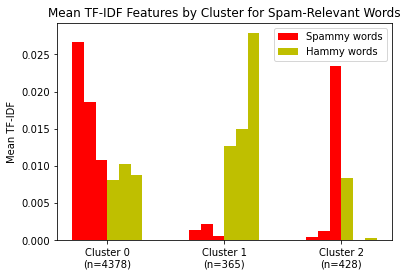

In [6]:
########################################################################
######################### Write your code here #########################
########################################################################

spammy_words=['click', 'www', 'offer']
#spammy_words=['click','apply','offer']
hammy_words=['meeting', 'attached', 'review']
spam_indices=[]
ham_indices=[]

spam_indices.extend([tf_vectorizer.vocabulary_[word] for word in spammy_words])
ham_indices.extend([tf_vectorizer.vocabulary_[word] for word in hammy_words])
plot_spam_words_by_cluster(gmm.predict(X_array), gmm.n_components, spam_indices, ham_indices)



### Part E: Interpret results 

From the plot generated in part (d), do any of the clusters correspond to spam emails, based on the frequency of spammy and hammy words? Do any of the clusters appear to correspond to typical business emails (ham)? 

Re-run your analysis with a different choice for the number of clusters in your GMM (e.g., `n_clusters=5` or `n_clusters=2`). How does changing the number of clusters affect your results? Does one choice of `n_clusters` appear better than another for locating clusters of spam emails?

*** ANSWER HERE IN TEXT ***  With n_clusters=3, the Cluster 0 is a mixture of spam and ham emails, although it contains more of spam emails. Similarly Cluster 2 shows a similar relation. Whereas, Cluster 1 is containing ham emails majorly.

With n_clusters=2, clusters have a mixture of spam and ham emails. No proper segregation

With n_clusters=5, clusters have segregated emails on the basis of spam and ham to a great extent.

We can say n_clusters=2/3 is not a value for k.

5 CLUSTER GRAPH


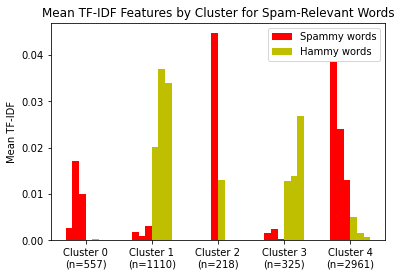

2 CLUSTER GRAPH


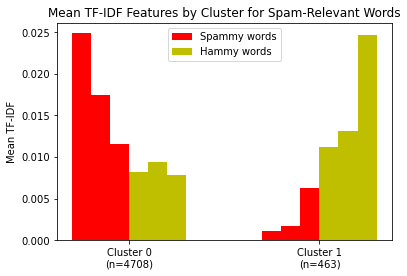

4 CLUSTER GRAPH


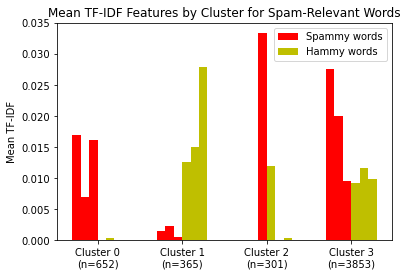

In [7]:
########################################################################
######################### Write your code here #########################
########################################################################
# n_clusters=5
print("5 CLUSTER GRAPH")
gmm=GaussianMixture(n_components=5,random_state=0,n_init=1)
gmm_fit=gmm.fit(X_array)
plot_spam_words_by_cluster(gmm.predict(X_array), gmm.n_components, spam_indices, ham_indices)

#n_clusters=2
print("2 CLUSTER GRAPH")
gmm=GaussianMixture(n_components=2,random_state=0,n_init=1)
gmm_fit=gmm.fit(X_array)
plot_spam_words_by_cluster(gmm.predict(X_array), gmm.n_components, spam_indices, ham_indices)

#n_clusters=4
print("4 CLUSTER GRAPH")
gmm=GaussianMixture(n_components=4,random_state=0,n_init=1)
gmm_fit=gmm.fit(X_array)
plot_spam_words_by_cluster(gmm.predict(X_array), gmm.n_components, spam_indices, ham_indices)
